# Momentum Strategy with Hurst and RSI
The purpose of this notebook is to implement a momentum trading strategy and test its efficacy on a portfolio of MAANG stocks between 01/01/2015 and 31/12/2019, using daily frequency data.  Our approach involves the utilization of Momentum, Hurst exponent, and RSI Indicator to determine the optimal term windows that would yield the best performance.  By using analytical methods, we aim to improve this strategy and turn it into an efficient trading mechanism.

## Step 0 Import Libraries
Let's import everything we need to run our backtesting algorithm


In [1]:
from ta.utils import dropna
from ta.volatility import BollingerBands
from ta.trend import ADXIndicator
from ta.volatility import AverageTrueRange
from ta.trend import SMAIndicator
from ta.momentum import RSIIndicator
from ta.volume import VolumeWeightedAveragePrice

import yfinance as yf
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hurst import compute_Hc

pd.options.mode.chained_assignment = None  # default='warn'

## Step 1 Strategy Develop
Momentum is an investment strategy based on the pursuit of stocks or assets that have performed well in the past. The basis of this strategy is a weak form of the market efficiency hypothesis, which states that past price information is already reflected in current prices. In programming, we can implement the momentum strategy by calculating the moving average of the stock price.

The Hurst index is a method used to quantify the long-term memory of a time series. Its value is between 0 and 1, and can be used to determine whether a time series is a random walk (Hurst index is approximately equal to 0.5), a continuous trend (Hurst index is greater than 0.5), or a reverse trend (Hurst index is less than 0.5).

The Relative Strength Index (RSI) is a commonly used technical analysis indicator that measures the speed and change of asset prices to identify overbought or oversold conditions. The value of RSI ranges from 0 to 100. Typically, when the RSI is greater than 70, the asset may be considered overbought, and when the RSI is less than 30, the asset may be considered oversold.

We first use the simplest single variable strategy

Rules --> Variables --> Parameters

Rule : 
      
      When long term and short term momentum less than 0: Short/Sell, i.e. Position = -1
      
      When long and short term momentum more than 0: Long/Buy, i.e. Position = 1
      
      When long and short term momentum do not have same trends: Hold, i.e. Position = 1
      
Variables : Long Term Momentum, Short Term Momentum

Parameters : short_term_window, long_term_window

In [2]:
# init methond to construct and provide all thevariables that will be required by the strategy
# start with single momentum strategy

class Momentum():

    def __init__(self, symbol, start, end, short_term_window, long_term_window, interval = '1d'):
        self.symbol = symbol
        self.start = start
        self.end = end
        self.ST_window = short_term_window
        self.LT_window = long_term_window
        self.interval = interval

        self.prepare_data()
    

    def prepare_data(self):

        stock_data = yf.Ticker(self.symbol)
        hist_stock = stock_data.history(start = self.start, end = self.end, interval = self.interval)

        bt_data = pd.DataFrame()
        bt_data['Close_Price'] = hist_stock['Close']

        # Calculate the momentum, short term and long term
        bt_data['ShortTermMomentum'] = bt_data['Close_Price'] - bt_data['Close_Price'].shift(self.ST_window)
        bt_data['LongTermMomentum'] = bt_data['Close_Price'] - bt_data['Close_Price'].shift(self.LT_window)    
        

        bt_data = bt_data.dropna()
        self.data = bt_data
    
    def stratrgy(self):
        data = self.data
        # momentum strategy, when long term and short term momentum are both positive, buy
        # when long term and short term momentum are both negative, sell
        
        data['Position'] = 1
        data.loc[(data['ShortTermMomentum'] > 0) & (data['LongTermMomentum'] > 0), 'Position'] = 1
        data.loc[(data['ShortTermMomentum'] < 0) & (data['LongTermMomentum'] < 0), 'Position'] = -1

        data['Signal'] = data['Position'].diff()
        data = data.dropna()

        data['Stock_Returns'] = np.log(data['Close_Price']/data['Close_Price'].shift(1))
        data['Strategy_Returns'] = data['Stock_Returns'] * data['Position'].shift(1)

        self.visualise_data = data
    
    def visualise_strategy(self):
        print('-------------------')
        print('Visualising the Strategy crossover period')
        bt_data = self.visualise_data
        plt.figure(figsize=(15, 5))
        plt.plot(bt_data["Close_Price"] ,color='black', label='Price', linestyle='dashed')
        plt.plot(bt_data["ShortTermMomentum"], color='b', label='Short term Momentum')
        plt.plot(bt_data["LongTermMomentum"], color='r', label='Long term Momentum')

        # plot ‘buy momentum’ signals.
        # Because I have used +1 and -1,
        # A buy signal will be created when the position was -1 and it turned to +1
        # difference of +1 - -1 will give me 2

        plt.plot(bt_data[bt_data['Signal'] == 2].index,
                bt_data['Close_Price'][bt_data['Signal'] == 2],
                '^', markersize = 15, color = 'g', label = 'buy/long')

        # plot ‘sell momentum ’ signals
        plt.plot(bt_data[bt_data['Signal'] == -2].index,
                bt_data['Close_Price'][bt_data['Signal'] == -2],
                'v', markersize = 15, color = 'r', label = 'sell/short')

        plt.xlabel("Days")
        plt.ylabel("Price")
        plt.title("Moving Averages Crossover {} Vs {}".format(self.ST_window, self.LT_window))
        plt.legend()
        plt.grid()
        plt.show()

    def performance(self):

        print('-------------------')
        print('Performance of the Strategy')
        print('-------------------')

        bt_data = self.visualise_data

        daily_ret = bt_data[['Stock_Returns', 'Strategy_Returns']].mean()
        annual_ret = daily_ret * 252
        annual_regular_ret = np.exp(annual_ret) - 1

        print('Annual Regular Return:', annual_regular_ret)

        daily_std = bt_data[['Stock_Returns', 'Strategy_Returns']].std()
        annual_std = daily_std * math.sqrt(252)
        daily_regular_std = (np.exp(bt_data[['Stock_Returns', 'Strategy_Returns']]) - 1).std()
        annual_regular_std = daily_regular_std * math.sqrt(252)

        print('Annual Regular Standard Deviation:', annual_regular_std)

        sr = annual_regular_ret / annual_regular_std

        print('Sharpe Ratio:', sr)

    def returns_plot(self):
        bt_data = self.visualise_data
        title = 'Returns plot for Momentum Strategy for {} Vs {}'.format(self.ST_window, self.LT_window)
        bt_data[['Stock_Returns', 'Strategy_Returns']].cumsum().plot(title = title, figsize=(15, 6))
        plt.show()

    def drawdown(self):
        bt_data = self.visualise_data
        bt_data['Gross_Cum_Returns'] = bt_data['Strategy_Returns'].cumsum().apply(np.exp)
        bt_data['Cum_Max'] = bt_data['Gross_Cum_Returns'].cummax()

        title = 'Drawdown for Momentum Strategy for {} Vs {}'.format(self.ST_window, self.LT_window)
        bt_data[['Gross_Cum_Returns', 'Cum_Max']].dropna().plot(title = title, figsize=(15, 6))

        drawdown = bt_data['Cum_Max'] - bt_data['Gross_Cum_Returns']

        print('The Maximum Drawdown is:', drawdown.max())
        print('-'*20)

        zero_periods = drawdown[drawdown == 0]
        delta_values = zero_periods.index[1:] - zero_periods.index[:-1]
        print('The Longest Drawdown period is:', delta_values.max())

-------------------
Running the Strategy for: AAPL
-------------------
-------------------
Running the Strategy for: GOOGL
-------------------
-------------------
Running the Strategy for: NFLX
-------------------
-------------------
Running the Strategy for: AMZN
-------------------
-------------------
Running the Strategy for: META
-------------------
-------------------
                           stock_returns_AAPL  strategy_returns_AAPL  \
Date                                                                   
2015-02-04 00:00:00-05:00                 NaN                    NaN   
2015-02-05 00:00:00-05:00            0.007112               0.007112   
2015-02-06 00:00:00-05:00           -0.008456              -0.008456   
2015-02-09 00:00:00-05:00            0.006621               0.006621   
2015-02-10 00:00:00-05:00            0.019029               0.019029   

                           stock_returns_GOOGL  strategy_returns_GOOGL  \
Date                                         

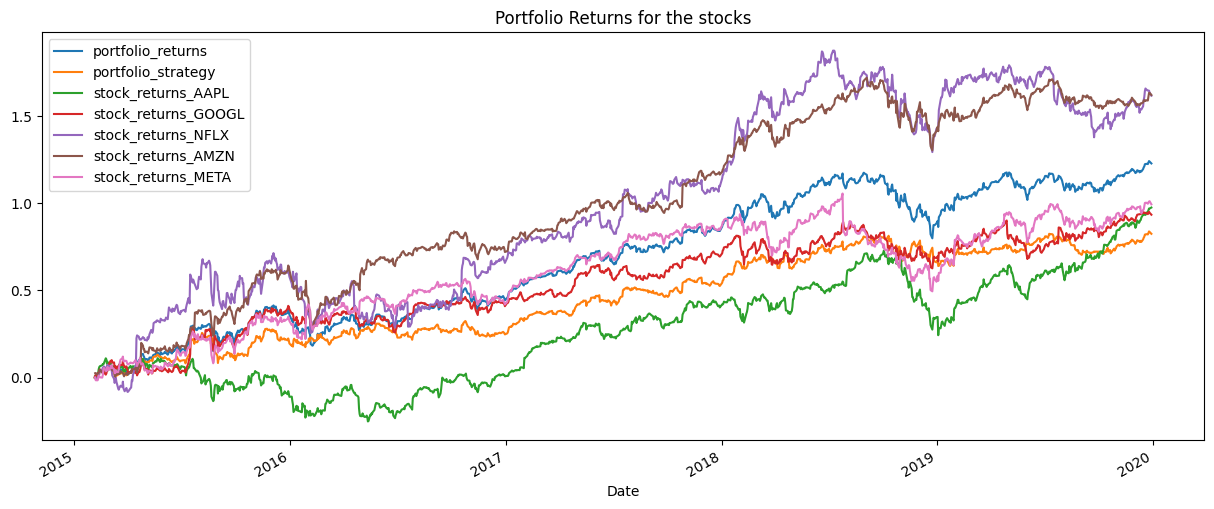

In [3]:
stocks = ['AAPL', 'GOOGL', 'NFLX', 'AMZN', 'META']

# Function to calculate annual return, annual standard deviation and Sharpe ratio for multiple stocks
def calculate_metrics(data, prefix):
    daily_ret = data.mean(axis=0)
    annual_ret = daily_ret * 252
    annual_regular_ret = np.exp(annual_ret) - 1

    daily_std = data.std()
    annual_std = daily_std * math.sqrt(252)
    daily_regular_std = (np.exp(data) - 1).std()
    annual_regular_std = daily_regular_std * math.sqrt(252)

    sr = daily_std / annual_std#annual_regular_ret / annual_regular_std
    print(f"Annual Return ({prefix}):", annual_ret, annual_regular_ret)
    print(f'Annual Std ({prefix}):', annual_std, annual_regular_std)
    print(f'Annual Regular Return ({prefix}):', annual_regular_ret)
    print(f'Annual Regular Standard Deviation ({prefix}):', annual_regular_std)
    print(f'Sharpe Ratio ({prefix}):', sr)

# for stock in stocks, run the strategy and store the results in one dataframe, finally plot the results in one plot
results = pd.DataFrame()

for stock in stocks:
    print('-------------------')
    print('Running the Strategy for:', stock)
    print('-------------------')
    momentum = Momentum(stock, '2015-01-01', '2019-12-31', 5, 21)
    momentum.stratrgy()
    results['stock_returns_'+ stock] = momentum.visualise_data['Stock_Returns']
    results['strategy_returns_'+ stock] = momentum.visualise_data['Strategy_Returns']

stock_returns = results.filter(like='stock')
strategy_returns = results.filter(like='strategy')

results['portfolio_returns'] = stock_returns.sum(axis=1) / len(stocks)
results['portfolio_strategy'] = strategy_returns.sum(axis=1) / len(stocks)
#results.to_csv('momentum_strategy.csv')
print('-------------------')
print(results.head())
plot_title = 'Portfolio Returns for the stocks'
columns_to_plot = ['portfolio_returns', 'portfolio_strategy'] + ['stock_returns_' + stock for stock in stocks]
results[columns_to_plot].cumsum().plot(title=plot_title, figsize=(15, 6))

calculate_metrics(results['portfolio_returns'], 'Portfolio Returns')
calculate_metrics(results['portfolio_strategy'], 'Portfolio Strategy')

## Conclusion
It is evident from the portfolio returns plot that the performance of the single momentum strategy falls short in comparison to the portfolio returns. Thus, it is imperative to explore more effective strategies that can yield better returns.


## Step 2: Strategy Improvement

Since single indicator do not have a better performance than the portfolio, I add Hurst exponent and RSI indicator to help settle the position.

Rules --> Variables --> Parameters

Rule : 
      
      When hurst more than 0, long term and short term momentum less than 0: Short/Sell, i.e. Position = -1
      
      When hurst more than 0, long and short term momentum greater than 0: Long/Buy, i.e. Position = 1
      
      When hurst more than 0, long and short term momentum do not have same trends: 
            
            When rsi less than 70: Long/Buy, i.e. Position = 1
            
            When rsi greater than 70: Short/Sell, i.e. Position = -1
      
      when hurst less than 0:
            
            When rsi less than 70: Long/Buy, i.e. Position = 1
            
            When rsi greater than 70: Short/Sell, i.e. Position = -1
      
Variables : Long Term Momentum, Short Term Momentum, RSI, Hurst

Parameters : short_term_window, long_term_window, hurst_window, rsi_window(same as short_term_window)

In [4]:
# init methond to construct and provide all thevariables that will be required by the strategy

class Momentum_Hurst_RSI():

    def __init__(self, symbol, start, end, short_term_window, long_term_window, hurst_window, interval = '1d'):
        self.symbol = symbol
        self.start = start
        self.end = end
        self.ST_window = short_term_window
        self.LT_window = long_term_window
        # Hurst exponent
        self.hurst_window = hurst_window

        self.interval = interval

        # RSI indicator, same as the short term window
        self.RSI_window = short_term_window

        self.prepare_data()
    

    def prepare_data(self):

        stock_data = yf.Ticker(self.symbol)
        hist_stock = stock_data.history(start = self.start, end = self.end, interval = self.interval)

        bt_data = pd.DataFrame()
        bt_data['Close_Price'] = hist_stock['Close']

        # Calculate the momentum and the Hurst exponent
        bt_data['ShortTermMomentum'] = bt_data['Close_Price'] - bt_data['Close_Price'].shift(self.ST_window)
        bt_data['LongTermMomentum'] = bt_data['Close_Price'] - bt_data['Close_Price'].shift(self.LT_window)    
        bt_data['Hurst'] = bt_data['Close_Price'].rolling(window=self.hurst_window).apply(lambda x: compute_Hc(x)[0])

        # Calculating the RSI
        rsi_indicator = RSIIndicator(close = hist_stock["Close"], window = self.RSI_window, fillna = False)
        RSI = rsi_indicator.rsi()

        # Adding the RSI to the dataframe
        bt_data['RSI'] = RSI

        bt_data = bt_data.dropna()
        self.data = bt_data
    
    def stratrgy(self):
        data = self.data
         
        # data['Position'] = 1
        data.loc[(data['Hurst'] > 0.5) & (data['ShortTermMomentum'] > 0) & (data['LongTermMomentum'] > 0), 'Position'] = 1 # Hurst exponent greater than 0.5, short term and long term momentum greater than 0, buy
        data.loc[(data['Hurst'] > 0.5) & (data['ShortTermMomentum'] < 0) & (data['LongTermMomentum'] < 0), 'Position'] = -1

        # Out of the market
        data.loc[(data['RSI'] <= 70) & (data['Hurst'] > 0.5) & ((data['ShortTermMomentum'] > 0) & (data['LongTermMomentum'] < 0) | (data['ShortTermMomentum'] < 0) & (data['LongTermMomentum'] > 0)), 'Position'] = 1
        data.loc[(data['RSI'] > 70) & (data['Hurst'] > 0.5) & ((data['ShortTermMomentum'] > 0) & (data['LongTermMomentum'] < 0) | (data['ShortTermMomentum'] < 0) & (data['LongTermMomentum'] > 0)), 'Position'] = -1
        data.loc[(data['Hurst'] < 0.5) & (data['RSI'] <= 70), 'Position'] = 1
        data.loc[(data['Hurst'] < 0.5) & (data['RSI'] > 70), 'Position'] = -1

        data['Signal'] = data['Position'].diff()
        data = data.dropna()

        data['Stock_Returns'] = np.log(data['Close_Price']/data['Close_Price'].shift(1))
        data['Strategy_Returns'] = data['Stock_Returns'] * data['Position'].shift(1)

        self.visualise_data = data
    
    def visualise_strategy(self):
        print('-------------------')
        print('Visualising the Strategy crossover period')
        bt_data = self.visualise_data
        plt.figure(figsize=(15, 5))
        plt.plot(bt_data["Close_Price"] ,color='black', label='Price', linestyle='dashed')
        plt.plot(bt_data["ShortTermMomentum"], color='b', label='Short term Momentum')
        plt.plot(bt_data["LongTermMomentum"], color='r', label='Long term Momentum')
        plt.plot(bt_data["Hurst"], color='g', label='Hurst Exponent')

        # plot ‘buy crossover’ signals.
        # Because I have used +1 and -1,
        # A buy signal will be created when the position was -1 and it turned to +1
        # difference of +1 - -1 will give me 2

        plt.plot(bt_data[bt_data['Signal'] == 2].index,
                bt_data['Close_Price'][bt_data['Signal'] == 2],
                '^', markersize = 15, color = 'g', label = 'buy/long')

        # plot ‘sell crossover ’ signals
        plt.plot(bt_data[bt_data['Signal'] == -2].index,
                bt_data['Close_Price'][bt_data['Signal'] == -2],
                'v', markersize = 15, color = 'r', label = 'sell/short')

        plt.xlabel("Days")
        plt.ylabel("Price")
        plt.title("Moving Averages Crossover {} Vs {}".format(self.ST_window, self.LT_window))
        plt.legend()
        plt.grid()
        plt.show()

    def performance(self):

        print('-------------------')
        print('Performance of the Strategy')
        print('-------------------')

        bt_data = self.visualise_data

        daily_ret = bt_data[['Stock_Returns', 'Strategy_Returns']].mean()
        annual_ret = daily_ret * 252
        annual_regular_ret = np.exp(annual_ret) - 1

        print('Annual Regular Return:', annual_regular_ret)

        daily_std = bt_data[['Stock_Returns', 'Strategy_Returns']].std()
        annual_std = daily_std * math.sqrt(252)
        daily_regular_std = (np.exp(bt_data[['Stock_Returns', 'Strategy_Returns']]) - 1).std()
        annual_regular_std = daily_regular_std * math.sqrt(252)

        print('Annual Regular Standard Deviation:', annual_regular_std)

        sr = annual_regular_ret / annual_regular_std

        print('Sharpe Ratio:', sr)

    def returns_plot(self):
        bt_data = self.visualise_data
        title = 'Returns plot for Momentum with Hurst Strategy for {} Vs {}'.format(self.ST_window, self.LT_window)
        bt_data[['Stock_Returns', 'Strategy_Returns']].cumsum().plot(title = title, figsize=(15, 6))
        plt.show()

    def drawdown(self):
        bt_data = self.visualise_data
        bt_data['Gross_Cum_Returns'] = bt_data['Strategy_Returns'].cumsum().apply(np.exp)
        bt_data['Cum_Max'] = bt_data['Gross_Cum_Returns'].cummax()

        title = 'Drawdown for Momentum with Hurst Strategy for {} Vs {}'.format(self.ST_window, self.LT_window)
        bt_data[['Gross_Cum_Returns', 'Cum_Max']].dropna().plot(title = title, figsize=(15, 6))

        drawdown = bt_data['Cum_Max'] - bt_data['Gross_Cum_Returns']

        print('The Maximum Drawdown is:', drawdown.max())
        print('-'*20)

        zero_periods = drawdown[drawdown == 0]
        delta_values = zero_periods.index[1:] - zero_periods.index[:-1]
        print('The Longest Drawdown period is:', delta_values.max())

-------------------
Running the Strategy for: AAPL
-------------------
-------------------
Running the Strategy for: GOOGL
-------------------
-------------------
Running the Strategy for: NFLX
-------------------
-------------------
Running the Strategy for: AMZN
-------------------
-------------------
Running the Strategy for: META
-------------------
Annual Return (Portfolio Returns): 0.22523231980886232 0.25261368936403117
Annual Std (Portfolio Returns): 0.22534324722491378 0.22507085530672635
Annual Regular Return (Portfolio Returns): 0.25261368936403117
Annual Regular Standard Deviation (Portfolio Returns): 0.22507085530672635
Sharpe Ratio (Portfolio Returns): 0.06299407883487121
Annual Return (Portfolio Strategy): 0.2352435107090231 0.26521682507000177
Annual Std (Portfolio Strategy): 0.15730733369867297 0.15743657097431865
Annual Regular Return (Portfolio Strategy): 0.26521682507000177
Annual Regular Standard Deviation (Portfolio Strategy): 0.15743657097431865
Sharpe Ratio (Por

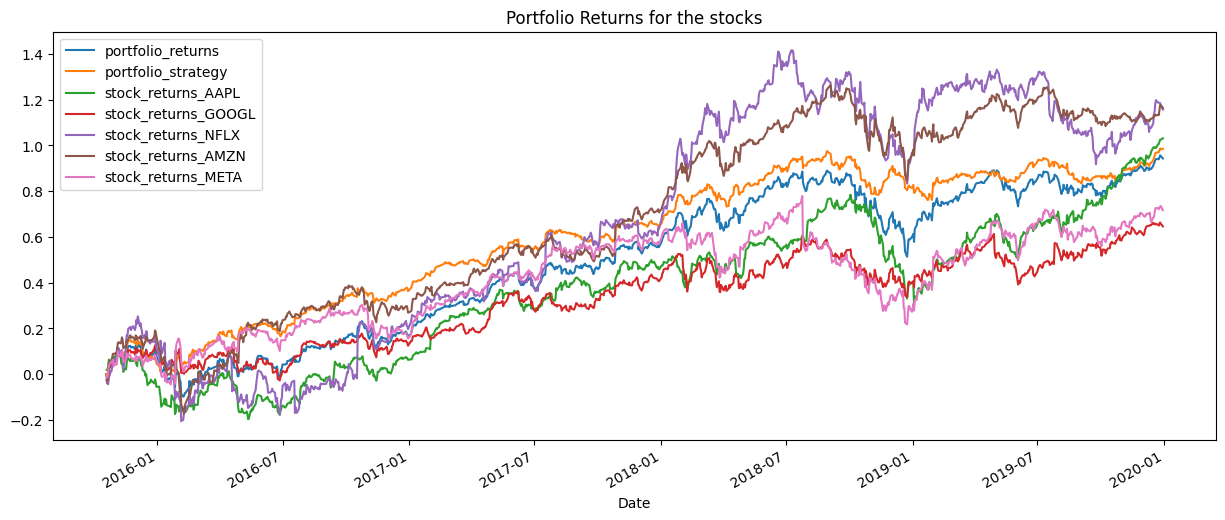

In [5]:
results2 = pd.DataFrame()

for stock in stocks:
    print('-------------------')
    print('Running the Strategy for:', stock)
    print('-------------------')
    momentum_hurst_rsi = Momentum_Hurst_RSI(stock, '2015-01-01', '2019-12-31', 5, 21, 200)
    momentum_hurst_rsi.stratrgy()
    results2['stock_returns_'+ stock] = momentum_hurst_rsi.visualise_data['Stock_Returns']
    results2['strategy_returns_'+ stock] = momentum_hurst_rsi.visualise_data['Strategy_Returns']

stock_returns2 = results2.filter(like='stock')
strategy_returns2 = results2.filter(like='strategy')

results2['portfolio_returns'] = stock_returns2.sum(axis=1) / len(stocks)
results2['portfolio_strategy'] = strategy_returns2.sum(axis=1) / len(stocks)

plot_title = 'Portfolio Returns for the stocks'
columns_to_plot = ['portfolio_returns', 'portfolio_strategy'] + ['stock_returns_' + stock for stock in stocks]
results2[columns_to_plot].cumsum().plot(title=plot_title, figsize=(15, 6))

calculate_metrics(results2['portfolio_returns'], 'Portfolio Returns')
calculate_metrics(results2['portfolio_strategy'], 'Portfolio Strategy')

## Conclusion 

Incorporating multiple indicators can be instrumental in enhancing the efficacy of trading strategies. By relying on a combination of these indicators, traders can make more informed decisions when it comes to buying and selling securities. This approach offers a more nuanced perspective, as it takes into account a variety of different factors that can influence market conditions. As such, utilizing multiple indicators can help traders to identify trends, anticipate market movements, and ultimately improve their overall performance.

## Step 3 Parameters Finetune

In the pursuit of achieving optimal investment results, it is crucial to develop a strategy that surpasses the conventional portfolio returns. To achieve this objective, it is imperative to meticulously fine-tune the parameters and determine the most suitable combination that would lead to improved performance. Therefore, a comprehensive evaluation of the parameters is necessary to ensure that the selected combination is not only effective but also efficient in the long run.

In [6]:
# Function to calculate annual return, annual standard deviation and Sharpe ratio for multiple stocks
def run_strategy_and_analyze(stocks, start_date, end_date, short_window, long_window, hurst_window):
    results = pd.DataFrame() # create an empty dataframe to store the results

    for stock in stocks:
        momentum_hurst_rsi = Momentum_Hurst_RSI(stock, start_date, end_date, short_window, long_window, hurst_window)
        momentum_hurst_rsi.stratrgy()
        results['stock_returns_'+ stock] = momentum_hurst_rsi.visualise_data['Stock_Returns']
        results['strategy_returns_'+ stock] = momentum_hurst_rsi.visualise_data['Strategy_Returns']
    # calculate the portfolio returns and strategy returns
    stock_returns = results.filter(like='stock')
    strategy_returns = results.filter(like='strategy')

    results['portfolio_returns'] = stock_returns.sum(axis=1) / len(stocks) # average of the stock returns
    results['portfolio_strategy'] = strategy_returns.sum(axis=1) / len(stocks) # average of the strategy returns

    plot_title = 'Portfolio Returns for the stocks'
    columns_to_plot = ['portfolio_returns', 'portfolio_strategy'] #+ ['stock_returns_' + stock for stock in stocks]
    results[columns_to_plot].cumsum().plot(title=plot_title, figsize=(15, 6))

    calculate_metrics(results['portfolio_returns'], 'Portfolio Returns')
    calculate_metrics(results['portfolio_strategy'], 'Portfolio Strategy')

    return results

Annual Return (Portfolio Returns): 0.22523231466900354 0.2526136829257737
Annual Std (Portfolio Returns): 0.22534323614633328 0.22507084435391556
Annual Regular Return (Portfolio Returns): 0.2526136829257737
Annual Regular Standard Deviation (Portfolio Returns): 0.22507084435391556
Sharpe Ratio (Portfolio Returns): 0.06299407883487121
Annual Return (Portfolio Strategy): 0.2352436668864504 0.2652170226683259
Annual Std (Portfolio Strategy): 0.157307288092655 0.15743652545786369
Annual Regular Return (Portfolio Strategy): 0.2652170226683259
Annual Regular Standard Deviation (Portfolio Strategy): 0.15743652545786369
Sharpe Ratio (Portfolio Strategy): 0.0629940788348712


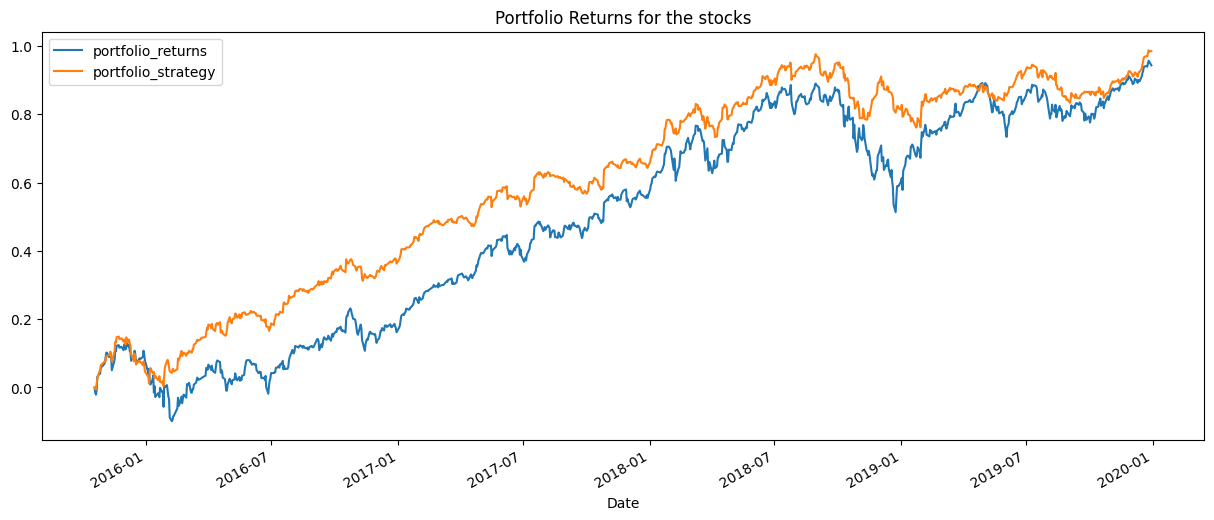

In [7]:
# Encapsulated function call， to run the strategy and analyze the results
stocks = ['AAPL', 'GOOGL', 'NFLX', 'AMZN', 'META']
start_date = '2015-01-01'
end_date = '2019-12-31'
short_window = 5
long_window = 21
hurst_window = 200

results2 = run_strategy_and_analyze(stocks, start_date, end_date, short_window, long_window, hurst_window=200)

-------------------
Running the Strategy for Short Window: 5
-------------------
Annual Return (Portfolio Returns): 0.22523231466900356 0.2526136829257737
Annual Std (Portfolio Returns): 0.22534327722593253 0.22507088570933115
Annual Regular Return (Portfolio Returns): 0.2526136829257737
Annual Regular Standard Deviation (Portfolio Returns): 0.22507088570933115
Sharpe Ratio (Portfolio Returns): 0.0629940788348712
Annual Return (Portfolio Strategy): 0.2352438553858186 0.2652172611609578
Annual Std (Portfolio Strategy): 0.15730735082085812 0.157436588260719
Annual Regular Return (Portfolio Strategy): 0.2652172611609578
Annual Regular Standard Deviation (Portfolio Strategy): 0.157436588260719
Sharpe Ratio (Portfolio Strategy): 0.0629940788348712
-------------------
Running the Strategy for Short Window: 10
-------------------
Annual Return (Portfolio Returns): 0.22658393367910323 0.2543078840912538
Annual Std (Portfolio Returns): 0.2255832485710611 0.22530808102121005
Annual Regular Retur

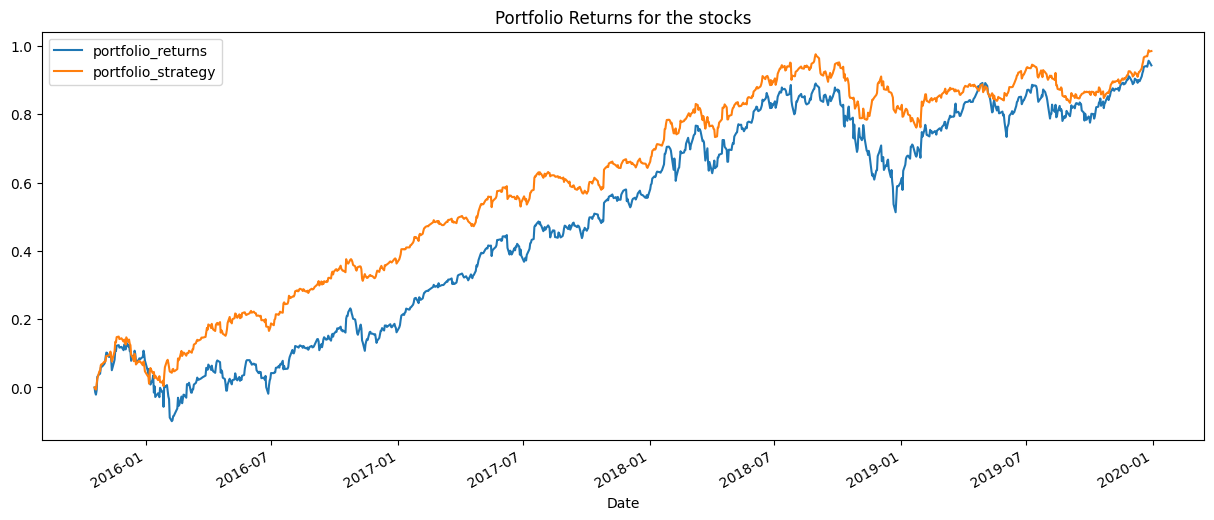

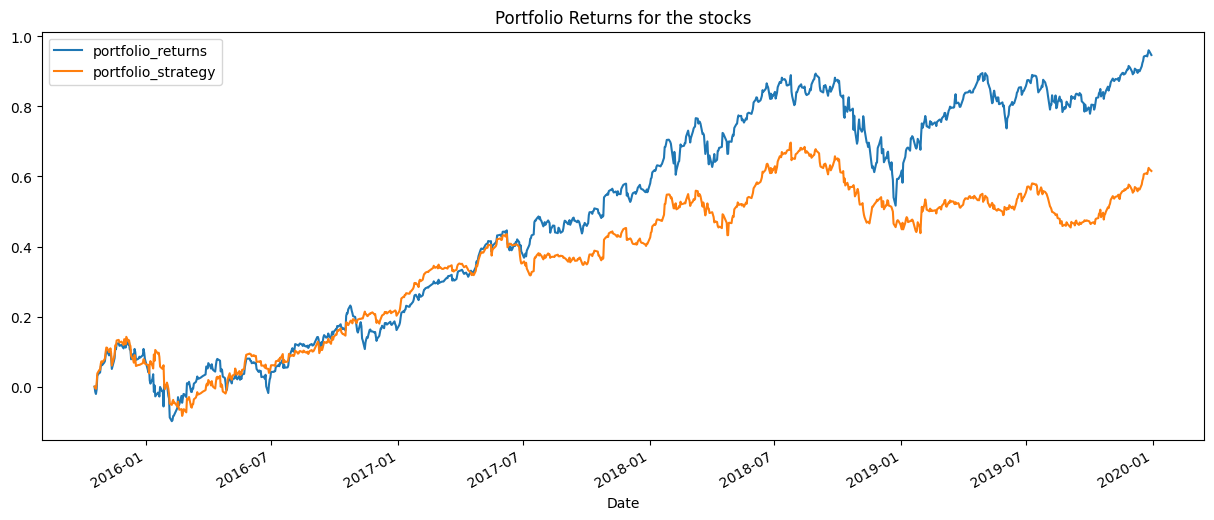

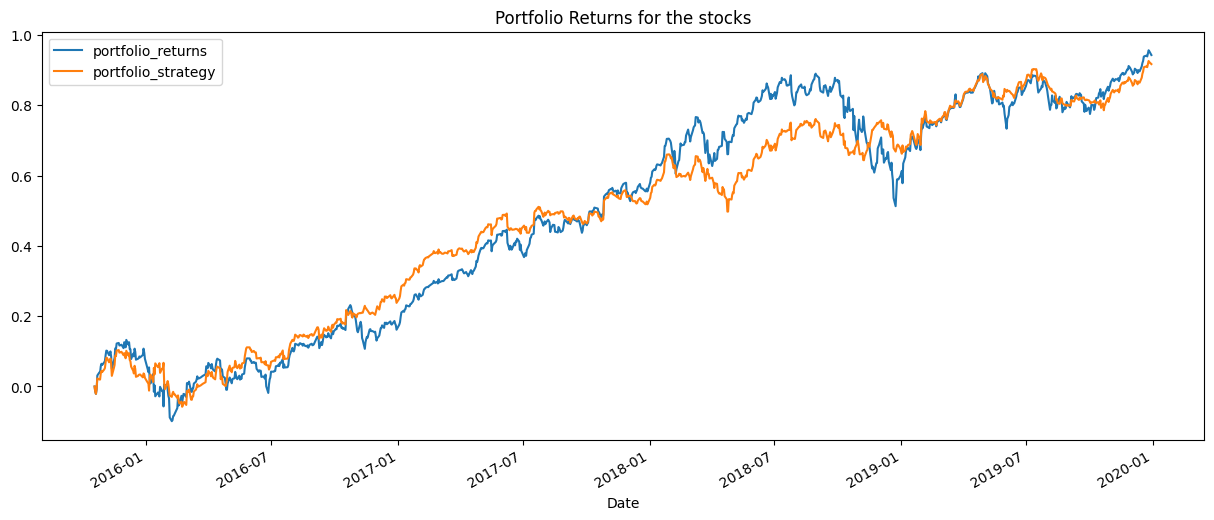

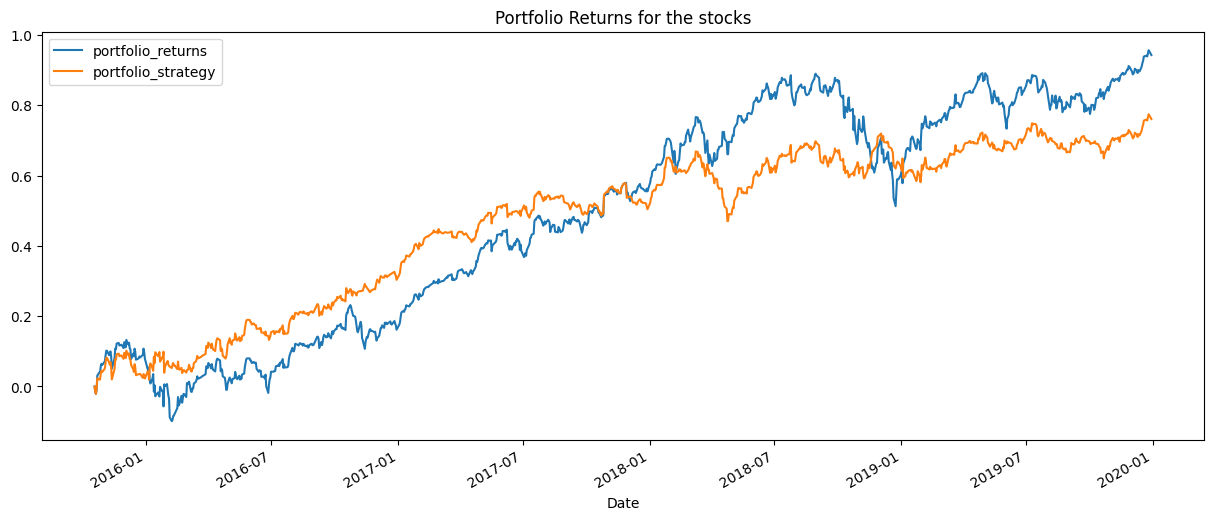

In [8]:
# Tune the parameters for the strategy, start with the short term window

for short_window in range(5, 21, 5):
    print('-------------------')
    print('Running the Strategy for Short Window:', short_window)
    print('-------------------')
    results2 = run_strategy_and_analyze(stocks, start_date, end_date, short_window, long_window, hurst_window=200)

## Comment

Based on our analysis, it appears that a window parameter value of 5 is the most optimal for short-term results. We will save these findings and proceed to evaluate additional parameters.

-------------------
Running the Strategy for Long Window: 11
-------------------
Annual Return (Portfolio Returns): 0.22519964849223967 0.2525727654941021
Annual Std (Portfolio Returns): 0.2253237725437913 0.22505103780098143
Annual Regular Return (Portfolio Returns): 0.2525727654941021
Annual Regular Standard Deviation (Portfolio Returns): 0.22505103780098143
Sharpe Ratio (Portfolio Returns): 0.0629940788348712
Annual Return (Portfolio Strategy): 0.194177724763026 0.21431207710582623
Annual Std (Portfolio Strategy): 0.1541850341277217 0.15422091184257747
Annual Regular Return (Portfolio Strategy): 0.21431207710582623
Annual Regular Standard Deviation (Portfolio Strategy): 0.15422091184257747
Sharpe Ratio (Portfolio Strategy): 0.06299407883487121
-------------------
Running the Strategy for Long Window: 21
-------------------
Annual Return (Portfolio Returns): 0.22523233268458692 0.2526137054923401
Annual Std (Portfolio Returns): 0.22534325262292226 0.22507086136452797
Annual Regular R

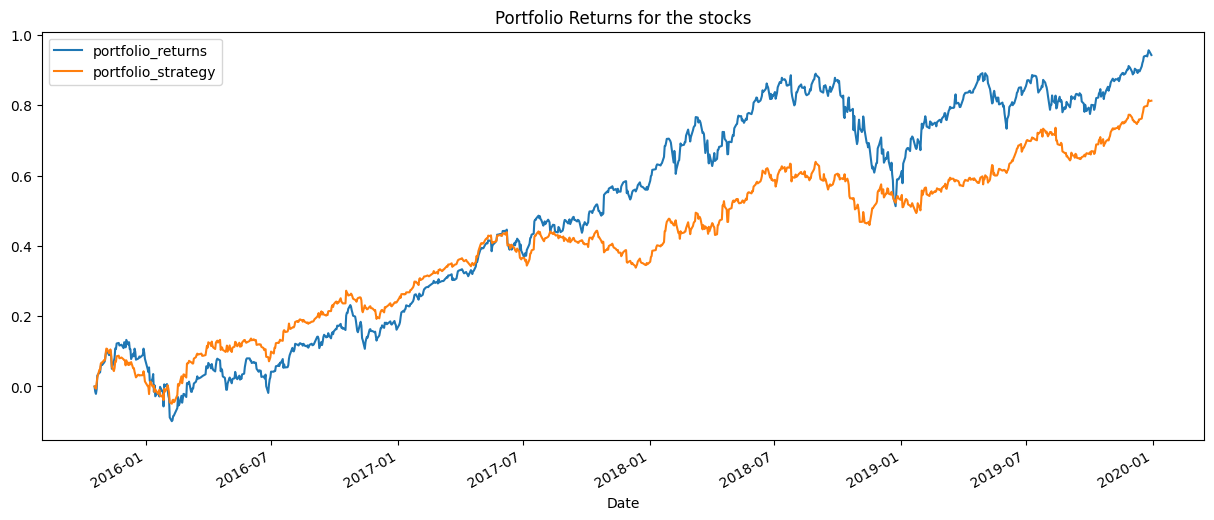

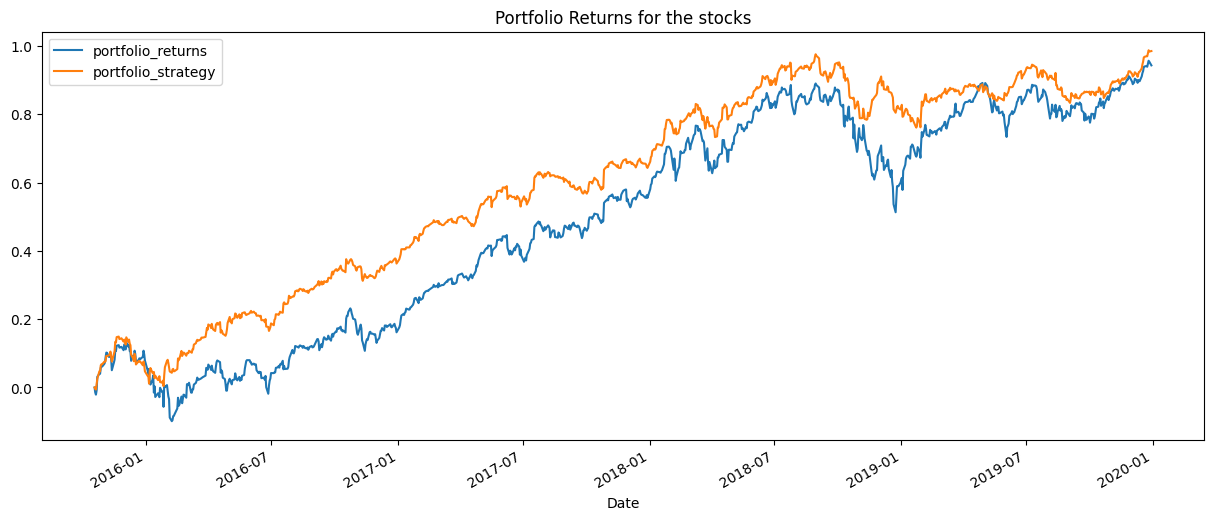

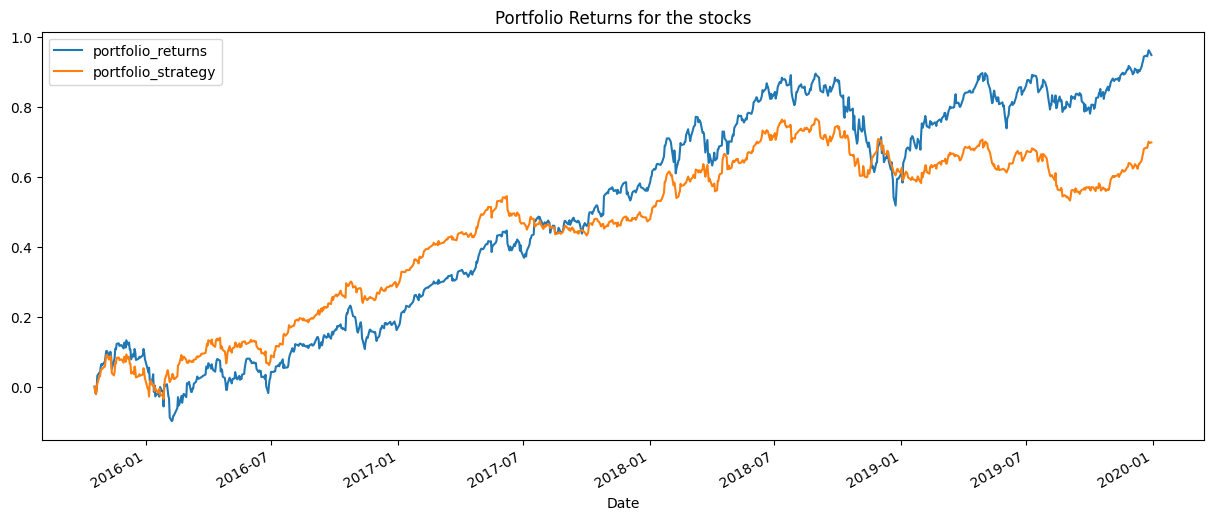

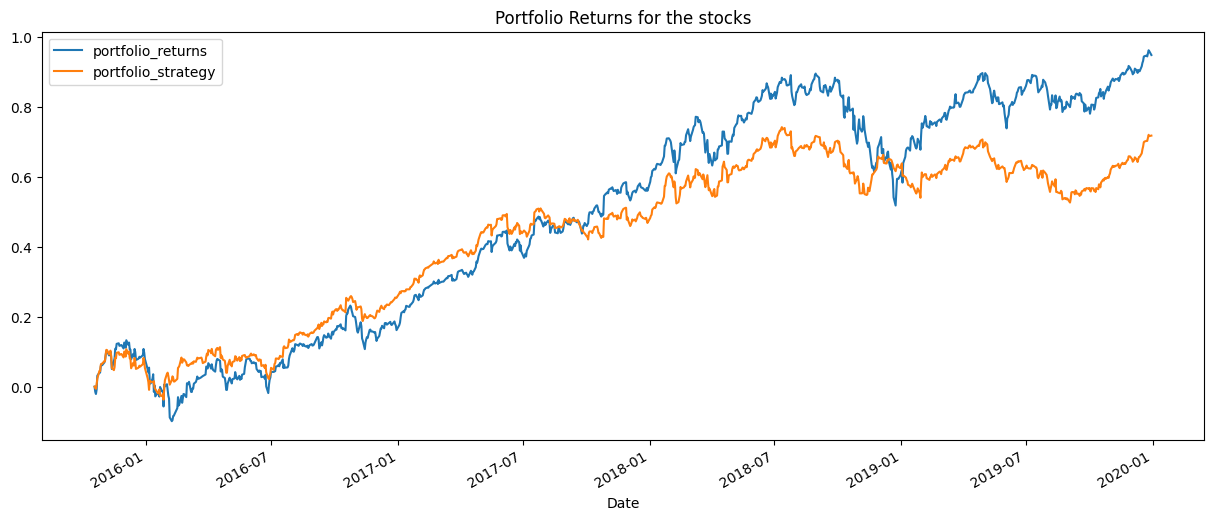

In [9]:
# Tune the parameters for the strategy, continue with the long term window
short_window = 5

for long_window in range(11, 42, 10):
    print('-------------------')
    print('Running the Strategy for Long Window:', long_window)
    print('-------------------')
    results2 = run_strategy_and_analyze(stocks, start_date, end_date, short_window, long_window, hurst_window=200)

## Comment

It appears that, for optimal performance, a long-term window value of 21 should be selected. Following this, the Hurst window parameter can be fine-tuned to further enhance results.

-------------------
Running the Strategy for Hurst Window: 100
-------------------
Annual Return (Portfolio Returns): 0.2369391253839775 0.2673639651322506
Annual Std (Portfolio Returns): 0.23022040870234065 0.23002817970456946
Annual Regular Return (Portfolio Returns): 0.2673639651322506
Annual Regular Standard Deviation (Portfolio Returns): 0.23002817970456946
Sharpe Ratio (Portfolio Returns): 0.0629940788348712
Annual Return (Portfolio Strategy): 0.15180628151706 0.16393473891943477
Annual Std (Portfolio Strategy): 0.16942276987897004 0.16914251490123378
Annual Regular Return (Portfolio Strategy): 0.16393473891943477
Annual Regular Standard Deviation (Portfolio Strategy): 0.16914251490123378
Sharpe Ratio (Portfolio Strategy): 0.06299407883487121
-------------------
Running the Strategy for Hurst Window: 200
-------------------
Annual Return (Portfolio Returns): 0.22523231980886232 0.25261368936403117
Annual Std (Portfolio Returns): 0.22534325431168167 0.22507086280234212
Annual Regu

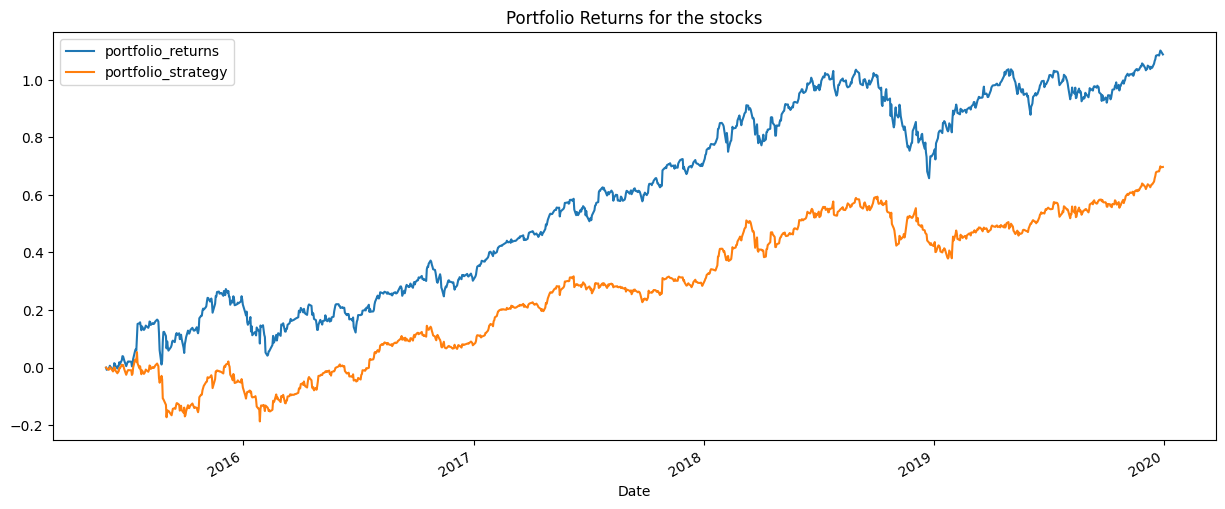

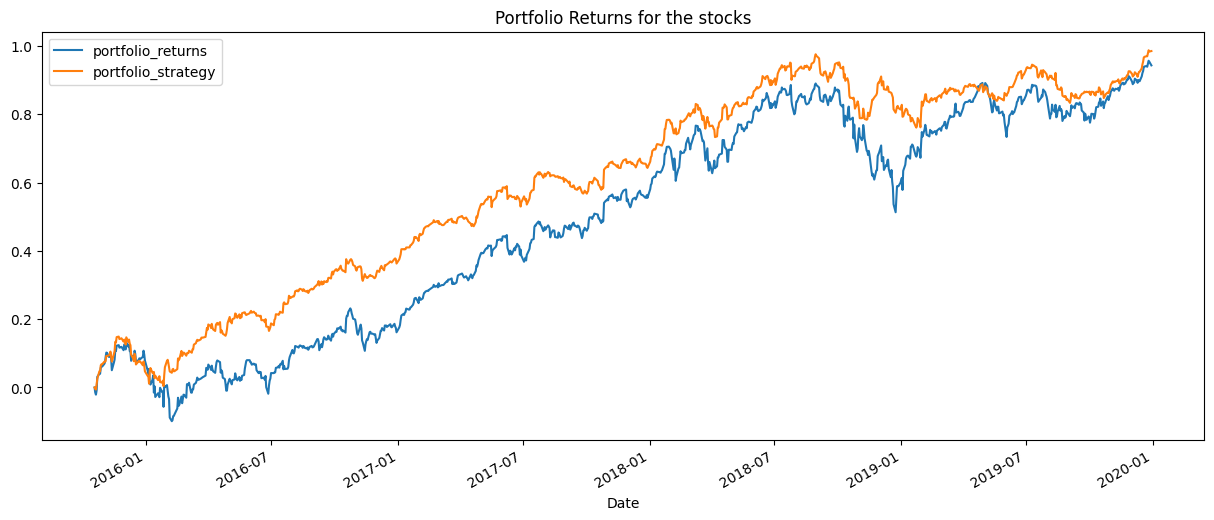

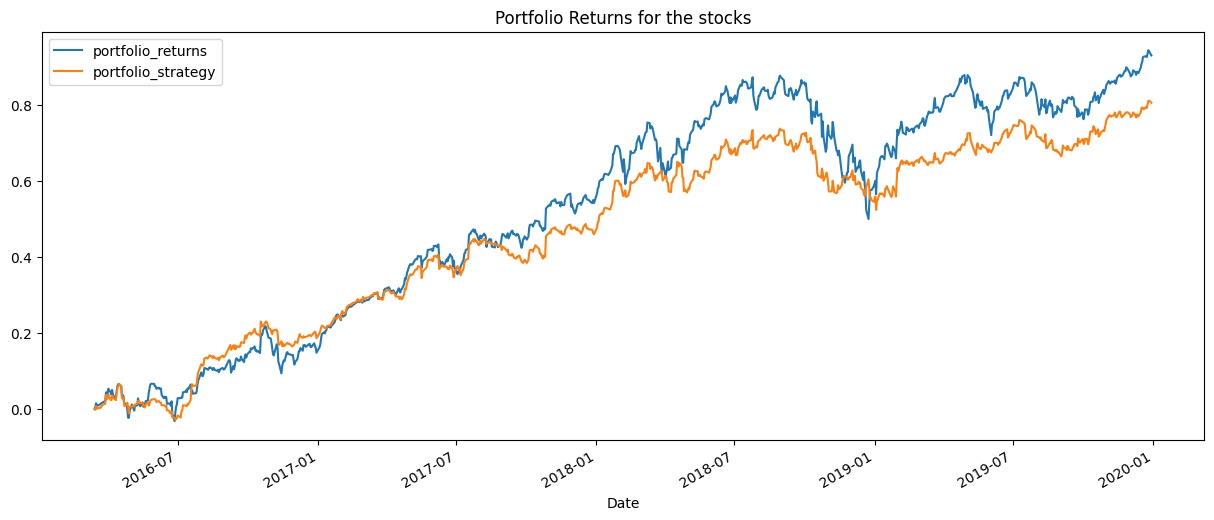

In [10]:
# Tune the parameters for the strategy, continue with the Hurst window
short_window = 5
long_window = 21

for hurst_window in range(100, 301, 100):
    print('-------------------')
    print('Running the Strategy for Hurst Window:', hurst_window)
    print('-------------------')
    results2 = run_strategy_and_analyze(stocks, start_date, end_date, short_window, long_window, hurst_window)

## Conclusioin

We can get the best suitable combination for this strategy to get the best perfomance:

    short term window = 5,
    long term window = 21,
    hurst window = 200

## Step 4 Strategy Perfomance Report

Report Strategy Risk, Returns, and performance metrics for MAANG stocks portfolio.

In [11]:
# Add drawdown analysis to the function
def run_strategy_and_analyze(stocks, start_date, end_date, short_window, long_window, hurst_window):
    results = pd.DataFrame()

    for stock in stocks:
        print('-------------------')
        print('Running the Strategy for:', stock)
        print('-------------------')
        momentum_hurst_rsi = Momentum_Hurst_RSI(stock, start_date, end_date, short_window, long_window, hurst_window)
        momentum_hurst_rsi.stratrgy()
        results['stock_returns_'+ stock] = momentum_hurst_rsi.visualise_data['Stock_Returns']
        results['strategy_returns_'+ stock] = momentum_hurst_rsi.visualise_data['Strategy_Returns']

    stock_returns = results.filter(like='stock')
    strategy_returns = results.filter(like='strategy')

    results['portfolio_returns'] = stock_returns.sum(axis=1) / len(stocks)
    results['portfolio_strategy'] = strategy_returns.sum(axis=1) / len(stocks)

    plot_title = 'Portfolio Returns for the stocks'
    columns_to_plot = ['portfolio_returns', 'portfolio_strategy'] + ['stock_returns_' + stock for stock in stocks]
    results[columns_to_plot].cumsum().plot(title=plot_title, figsize=(15, 6))

    calculate_metrics(results['portfolio_returns'], 'Portfolio Returns')
    calculate_metrics(results['portfolio_strategy'], 'Portfolio Strategy')

    # Calculate and plot drawdown
    results['cumulative_portfolio_strategy'] = results['portfolio_strategy'].cumsum()
    results['cum_max'] = results['cumulative_portfolio_strategy'].cummax()

    title = 'Drawdown for Momentum with Hurst and RSI Strategy'
    results[['cumulative_portfolio_strategy', 'cum_max']].dropna().plot(title = title, figsize=(15, 6))
    
    drawdown = results['cum_max'] - results['cumulative_portfolio_strategy']

    print('The Maximum Drawdown is:', drawdown.max())
    zero_periods = drawdown[drawdown == 0]
    delta_values = zero_periods.index[1:] - zero_periods.index[:-1]
    print('The Longest Drawdown period is:', delta_values.max())
    
    return results

-------------------
Running the Strategy for: AAPL
-------------------
-------------------
Running the Strategy for: GOOGL
-------------------
-------------------
Running the Strategy for: NFLX
-------------------
-------------------
Running the Strategy for: AMZN
-------------------
-------------------
Running the Strategy for: META
-------------------
Annual Return (Portfolio Returns): 0.22523231466900356 0.2526136829257737
Annual Std (Portfolio Returns): 0.22534325739754263 0.22507086576886629
Annual Regular Return (Portfolio Returns): 0.2526136829257737
Annual Regular Standard Deviation (Portfolio Returns): 0.22507086576886629
Sharpe Ratio (Portfolio Returns): 0.06299407883487121
Annual Return (Portfolio Strategy): 0.23524351689900175 0.26521683290166687
Annual Std (Portfolio Strategy): 0.15730730959318606 0.15743654728860051
Annual Regular Return (Portfolio Strategy): 0.26521683290166687
Annual Regular Standard Deviation (Portfolio Strategy): 0.15743654728860051
Sharpe Ratio (Port

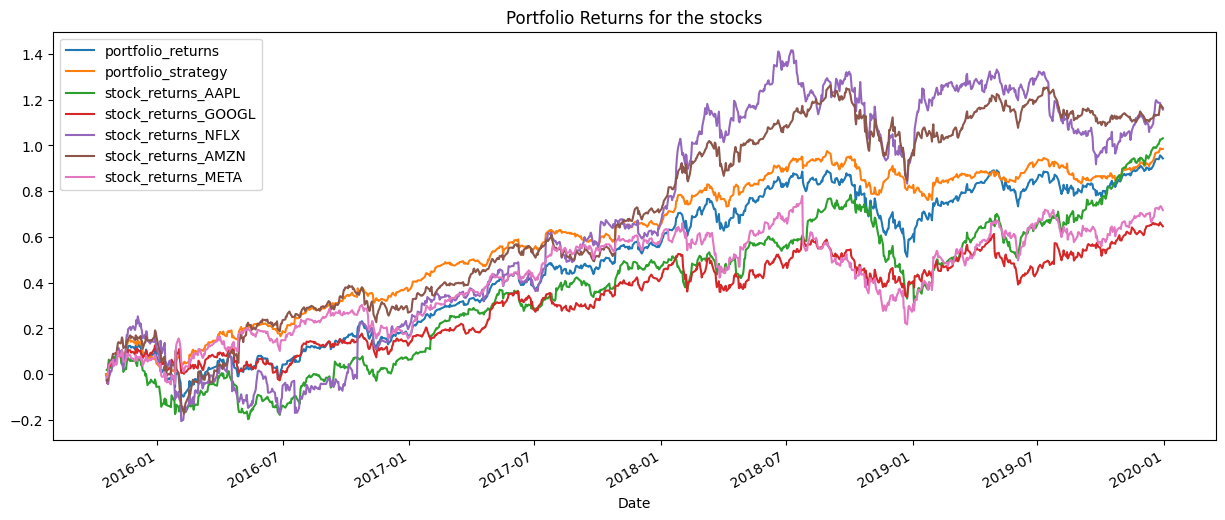

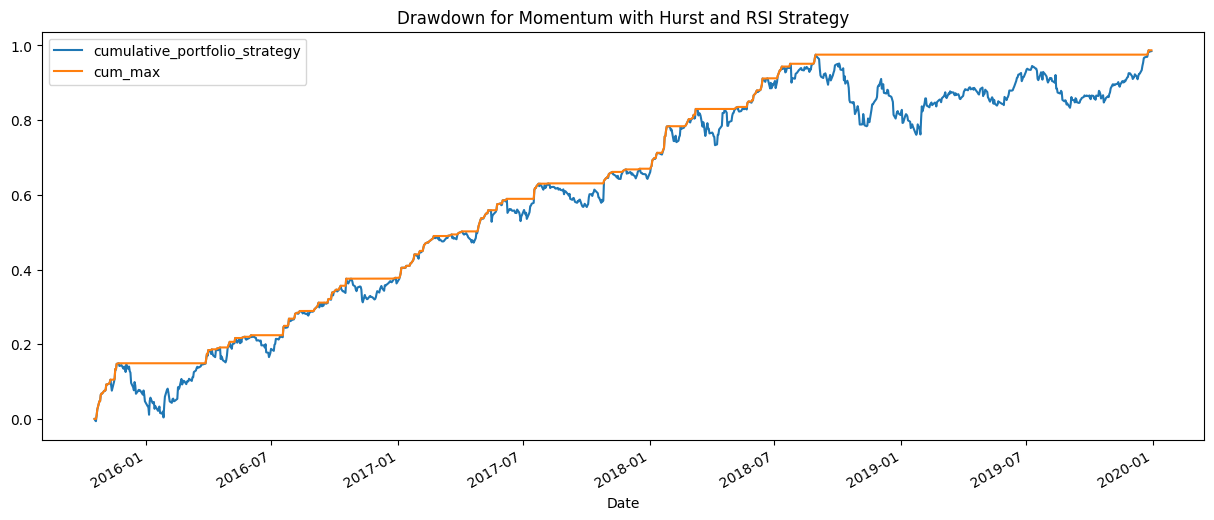

In [12]:
 # report Strategy Risk, Returns, and performance metrics for MAANG stocks portfolio.
stocks = ['AAPL', 'GOOGL', 'NFLX', 'AMZN', 'META']
start_date = '2015-01-01'
end_date = '2019-12-31'
short_window = 5
long_window = 21
hurst_window = 200

results = run_strategy_and_analyze(stocks, start_date, end_date, short_window, long_window, hurst_window)